In [91]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

plt.rcParams["figure.figsize"] = (12,9)

In [106]:
def get_data(person: str):
    path = f'data/0423/{person}-hangboard/data_labelled.csv'
    with open(path, 'r') as fp:
        data_raw = pd.read_csv(fp)
        
    X = data_raw[[f'EMG{i}' for i in range(8)]]
    holds = data_raw['hold'] + '_' + data_raw['details']
    names = pd.Series([person] * len(holds))
    return X, holds, names

In [107]:
X, holds, names = (
    pd.concat(col).reset_index(drop=True) for col in zip(*[
        get_data(name) for name in ['jonas', 'gregor', 'nikolai', 'jannis'
    ]])
)

In [50]:
tsne = TSNE(2)
X_tsne = tsne.fit_transform(X)

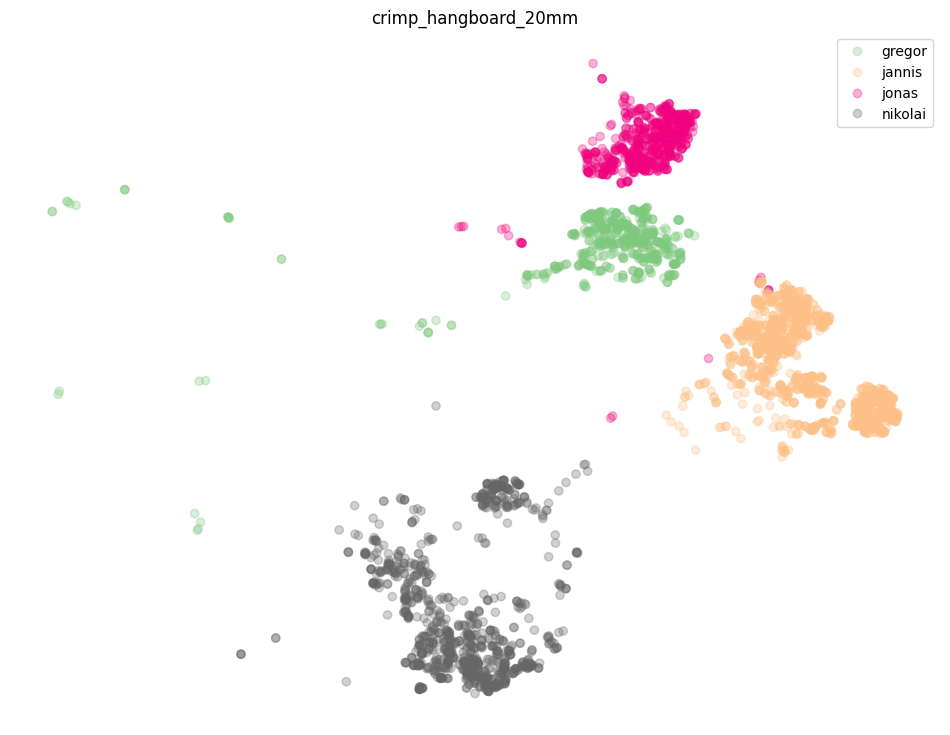

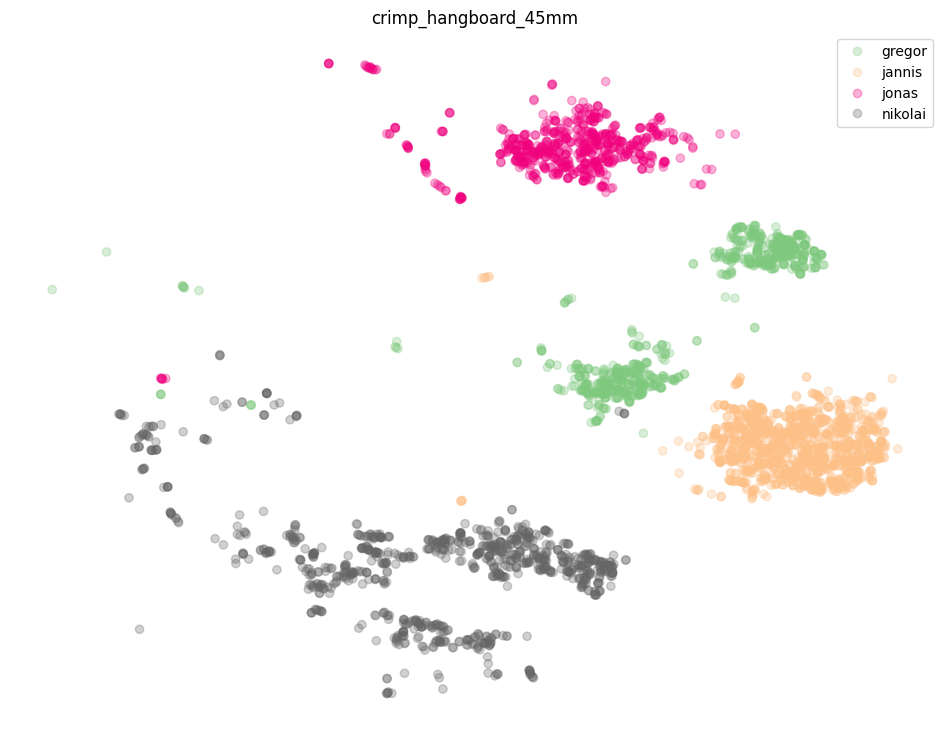

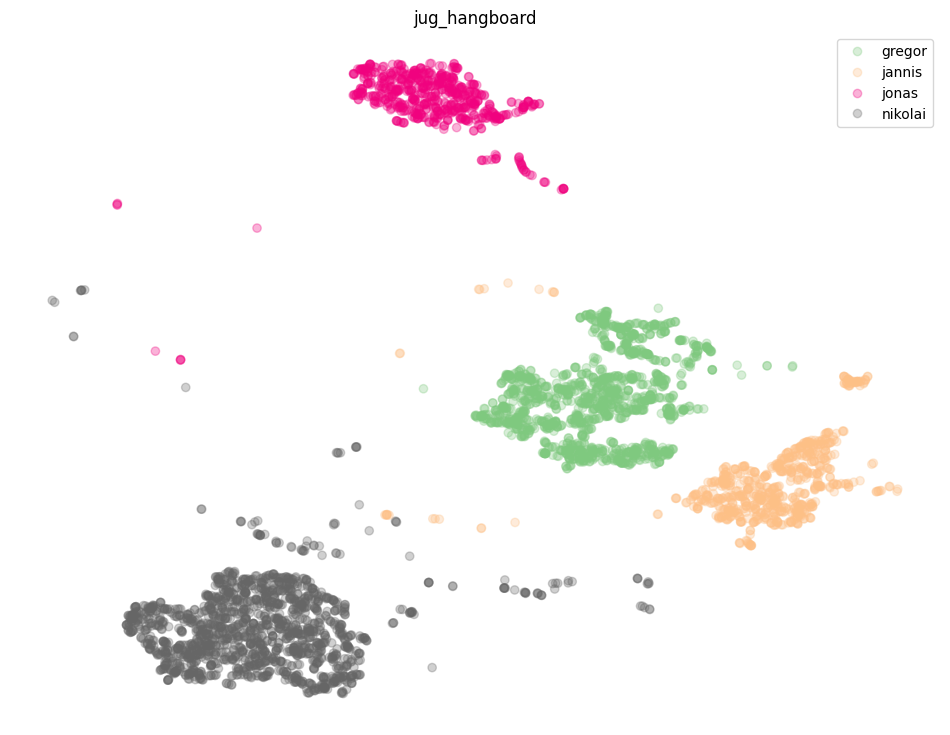

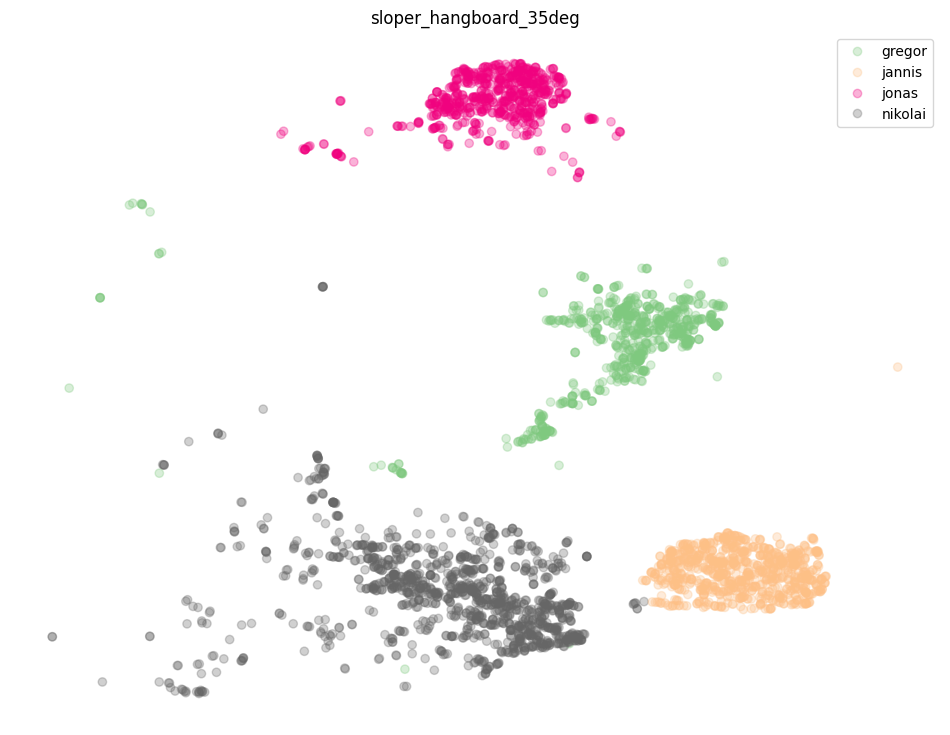

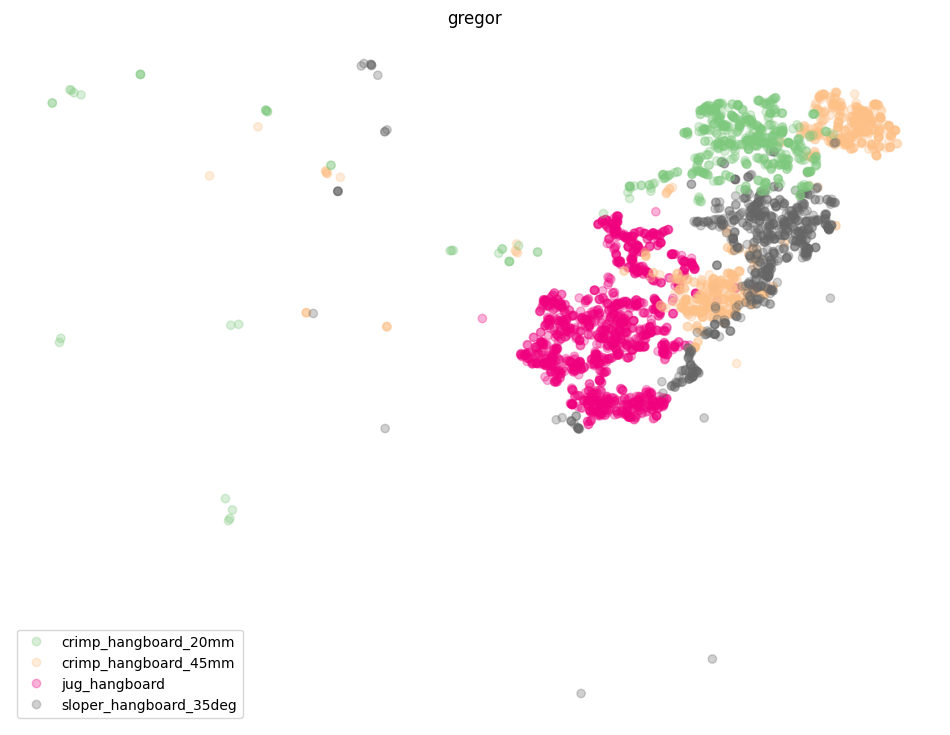

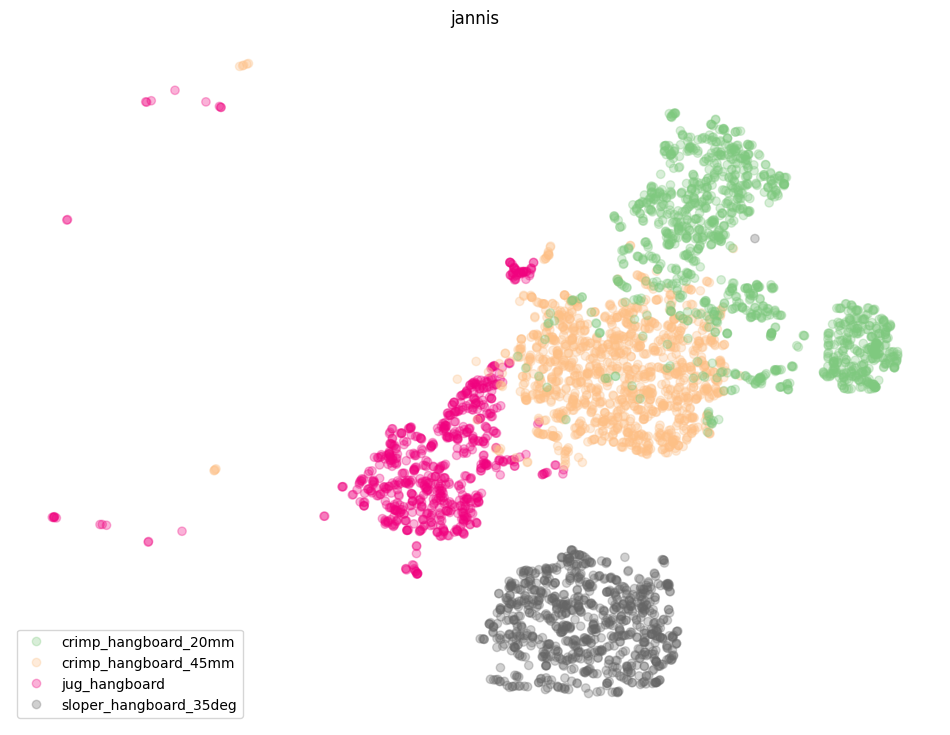

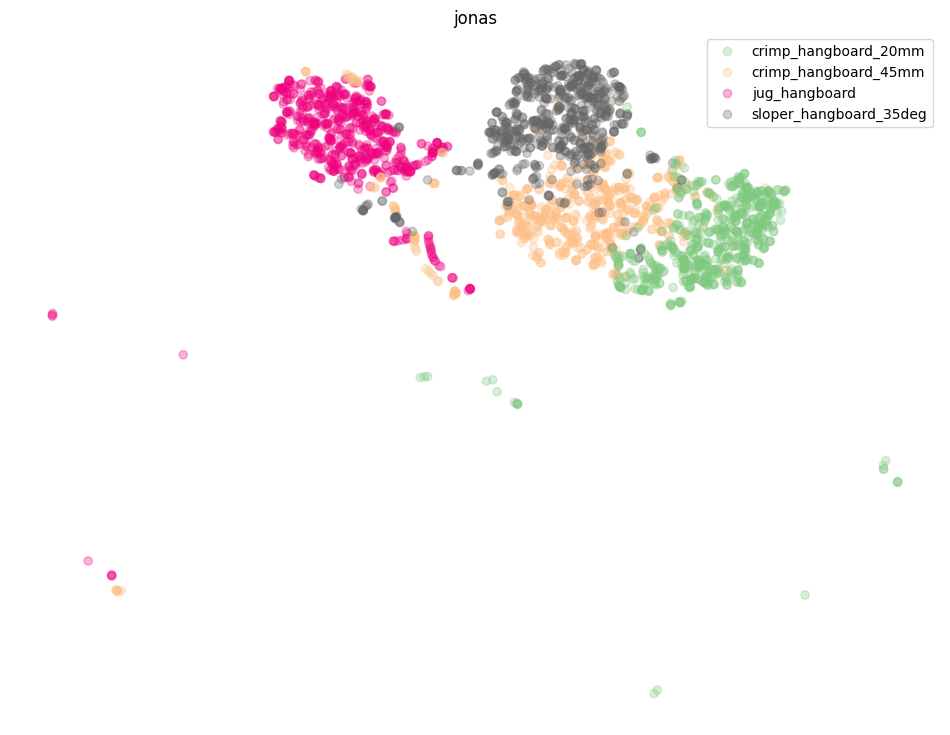

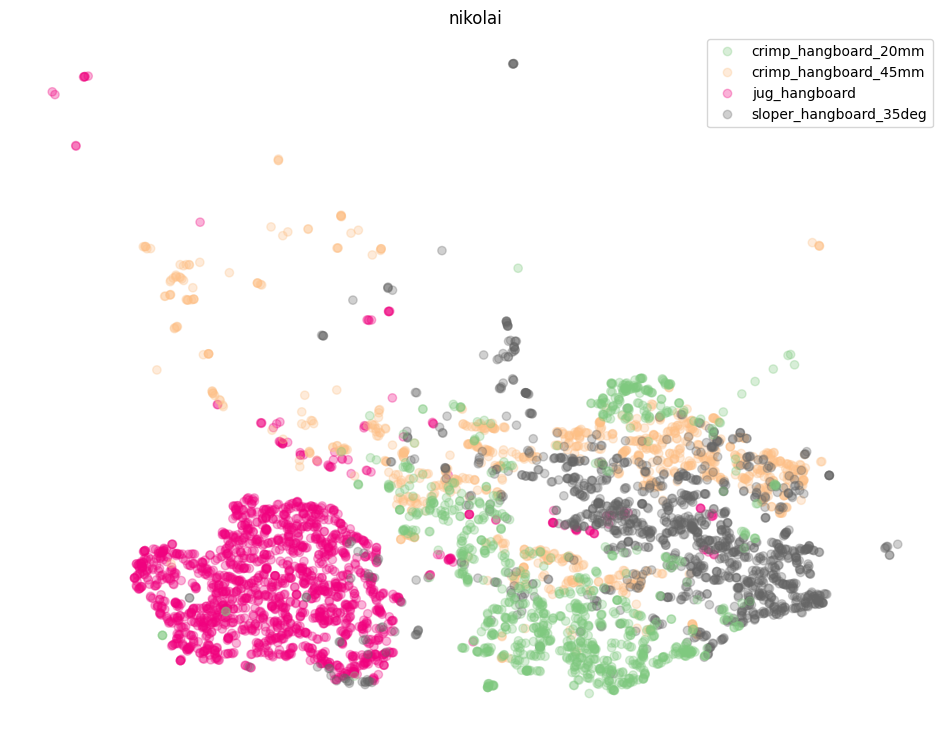

<Figure size 1200x900 with 0 Axes>

In [51]:
hold_labels = pd.Categorical(holds)
name_labels = pd.Categorical(names)

def _plot(condition, colors, title, save=False):
    plot = plt.scatter(
        X_tsne[condition,0], X_tsne[condition,1],
        c=colors.codes[condition],
        alpha=0.3, cmap='Accent')
    plt.legend(handles=plot.legend_elements()[0], labels=list(colors.categories))
    plt.title(title)
    plt.axis('off')
    if save:
        plt.savefig(f'{title}.png')
    else:
        plt.show()

for h in hold_labels.categories:
    _plot(holds == h, name_labels, h)
    plt.clf()
    
for n in name_labels.categories:
    _plot((names == n) & (~holds.isna()), hold_labels, n)
    plt.clf()

In [110]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

y = holds.fillna('idle')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)
classifier = RandomForestClassifier(random_state=0)
classifier.fit(X_train, y_train)

y_pred = pd.Series(classifier.predict(X_test))
y_pred.index = y_test.index

# Overall

accuracy: 0.891960759332399


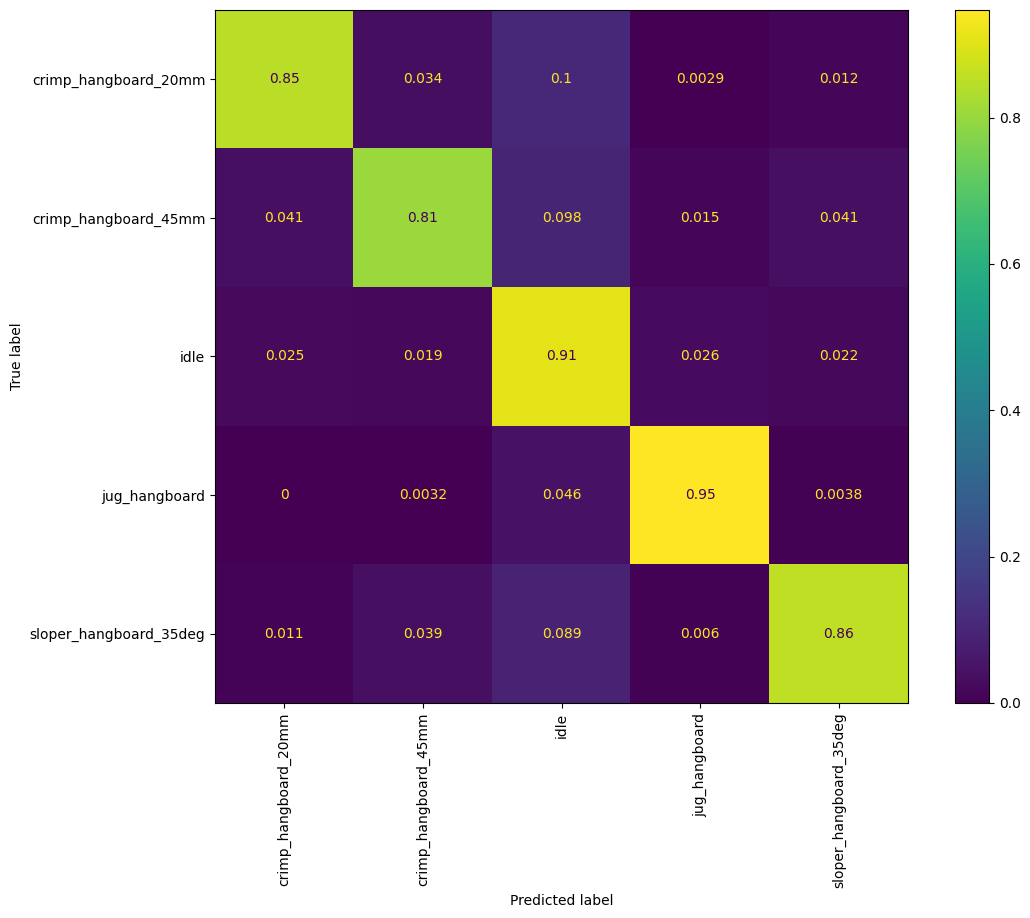

# gregor

accuracy: 0.9011929460580913


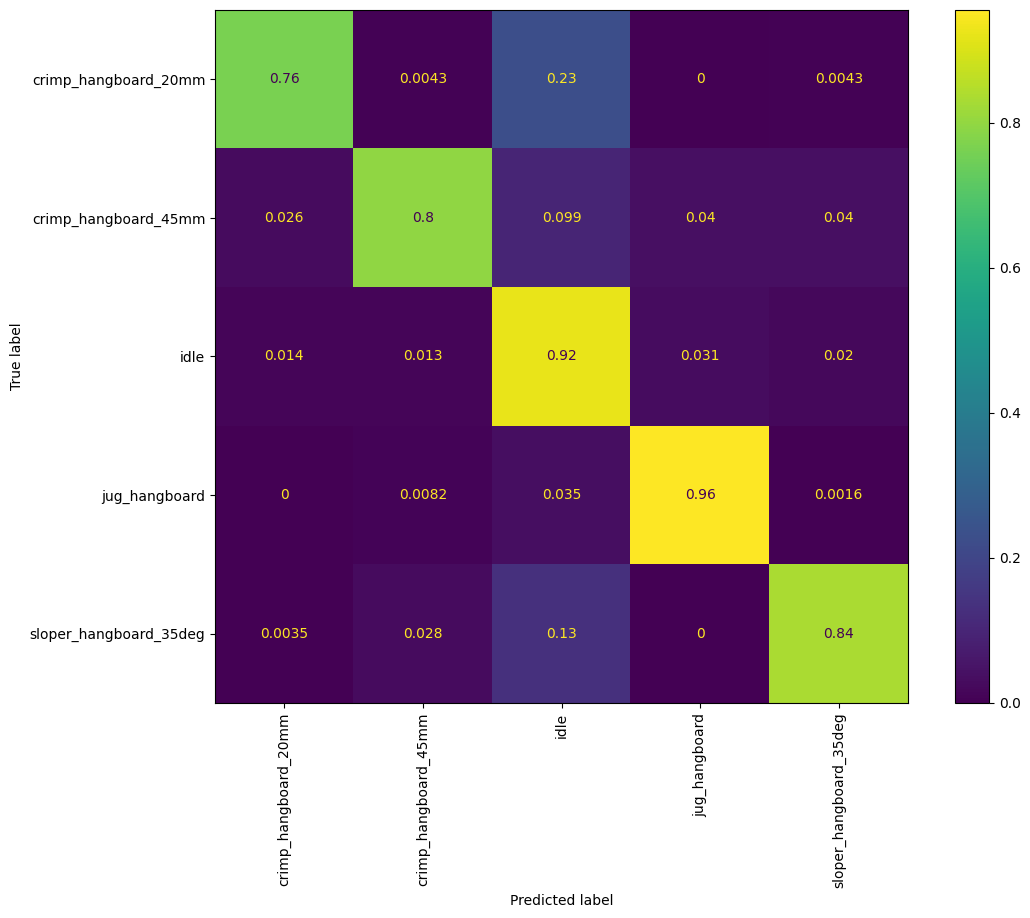

# jannis

accuracy: 0.8907877169559413


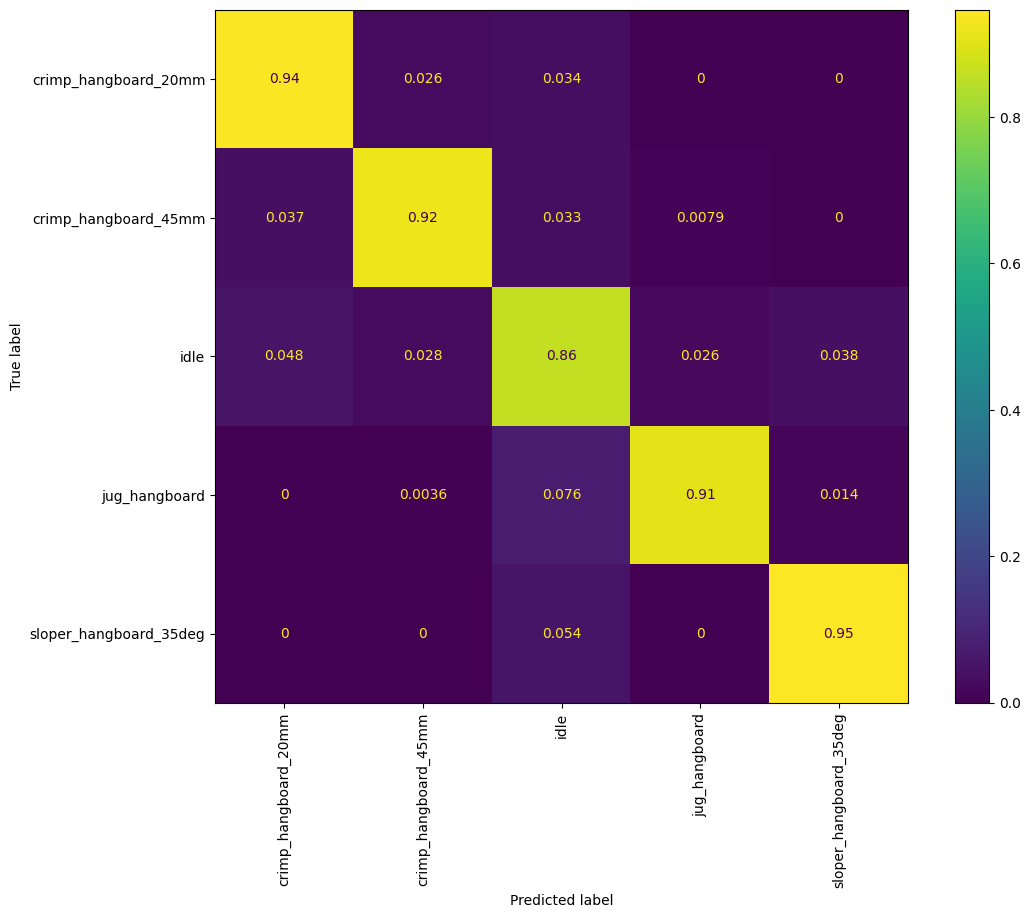

# jonas

accuracy: 0.8910579345088161


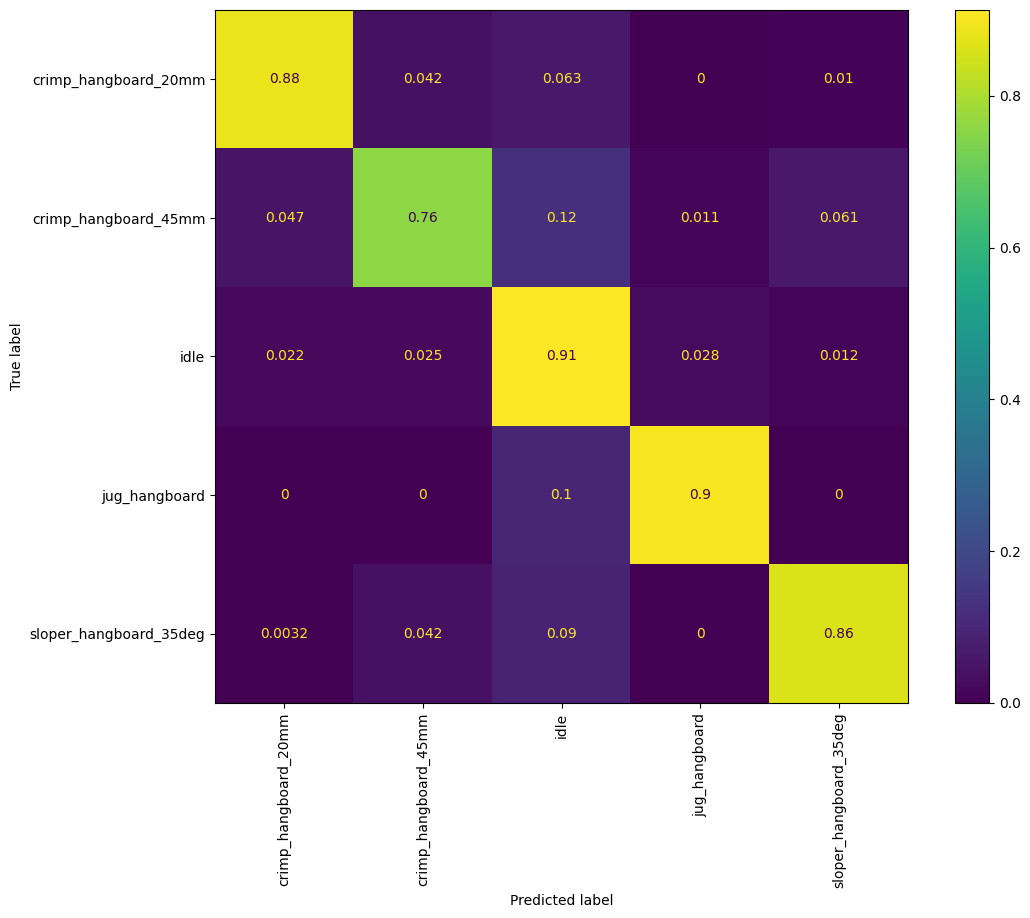

# nikolai

accuracy: 0.8862019914651493


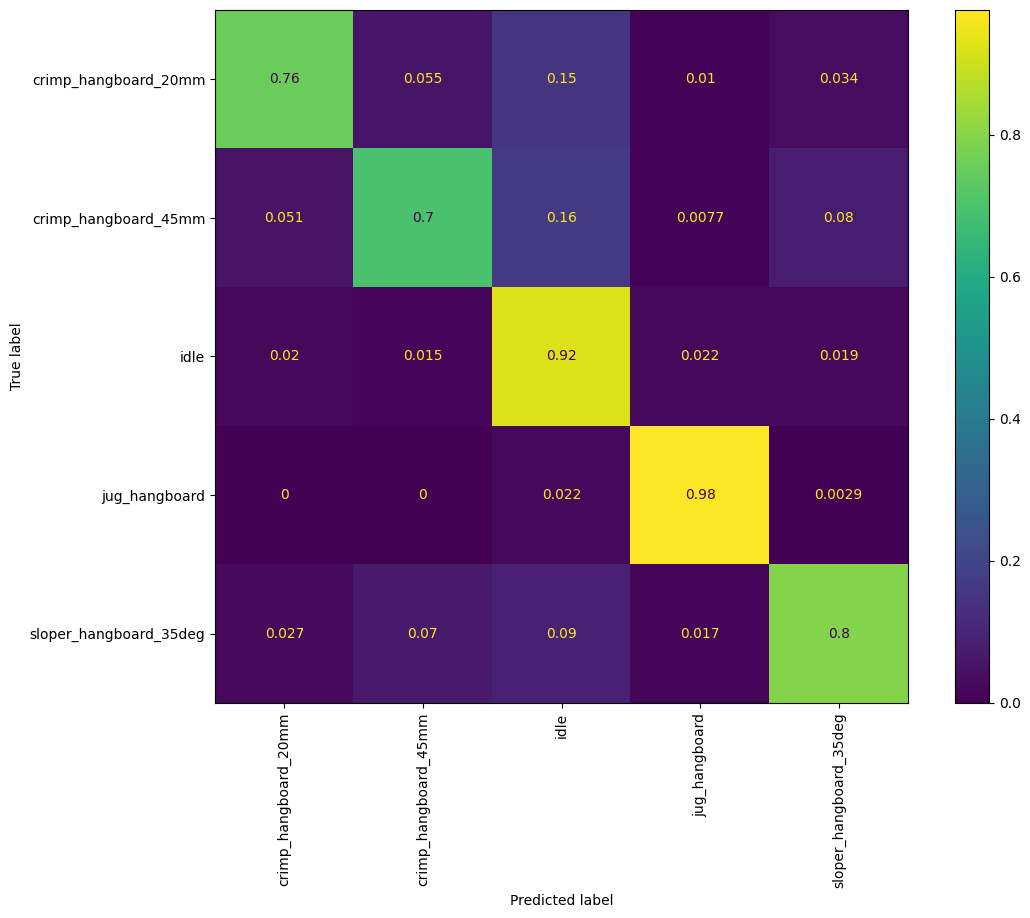

In [111]:
def _report(title, t, p):
    display(Markdown(f'# {title}'))
    print(f'accuracy: {accuracy_score(t, p)}')
    ConfusionMatrixDisplay.from_predictions(
        t, p,
        labels=classifier.classes_,
        normalize='true',
        xticks_rotation='vertical'
    )
    plt.show()

_report('Overall', y_test, y_pred)
names_test = names[y_test.index]
for name in pd.Categorical(names).categories:
    idx = names_test[names_test == name].index
    _report(name, y_test[idx], y_pred[idx])